# Librairies

In [ ]:
pip install -U PyYAML

     |████████████████████████████████| 596 kB 14.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%reload_ext autoreload
%autoreload 2

from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import sys
import os

from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/MyDrive/colab/perso/gan-modern-art')

from tools.build import build_generator, build_discriminator
from tools.image import save_images
from tools.config import Config

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [ ]:
def load_discriminator(retrain, config, suffix=''):
    
    optimizer = Adam(1.5e-4, 0.5)
    
    if retrain :
        model = load_model('history/model/discriminator'+suffix)
    else :
        model = build_discriminator(config)

    model.compile(loss='binary_crossentropy',
                    optimizer = optimizer, metrics=['accuracy'])
    model.trainable = True
    
    return model


def load_generator(retrain, compile, suffix=''):
    if retrain :
            if compile:
                model = load_model('history/model/generator'+suffix)
            else:
                model = load_model('history/model/generator'+suffix, compile=False)
    else :
        model = build_generator(config)
    
    return model
    

def save_models(generator, discriminator, suffix=''):
    generator.save('history/model/generator'+suffix)
    discriminator.save('history/model/discriminator'+suffix)

In [ ]:
retrain = True
config = Config('config.yaml')
training_data = np.load(config.IMAGE_DIR+'cubism_data.npy')

discriminator = load_discriminator(retrain, config)
generator = load_generator(retrain, compile=False)

random_input = Input(shape=(config.NOISE_SIZE,))
generated_image = generator(random_input)
validity = discriminator(generated_image)

optimizer = Adam(1.5e-4, 0.5)
combined = Model(random_input, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

y_real = np.ones((config.BATCH_SIZE, 1))
y_fake = np.zeros((config.BATCH_SIZE, 1))
fixed_noise = np.random.normal(0, 1, (config.PREVIEW_ROWS * config.PREVIEW_COLS, config.NOISE_SIZE))

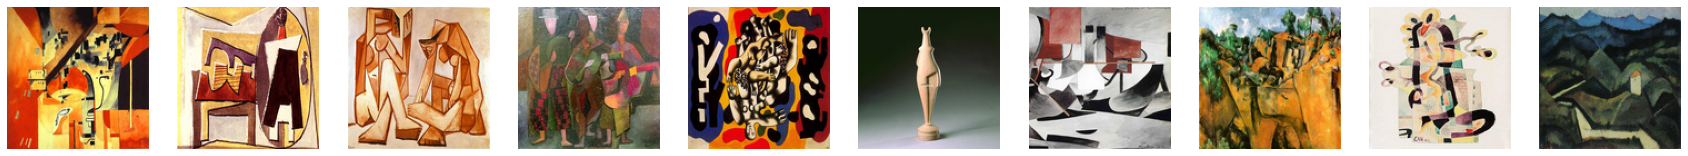

In [ ]:
plt.figure(figsize=(30,10))

for i in range(10):
    plt.subplot(1,10,1+i)
    plt.axis('off')
    plt.imshow(((training_data[i]+1)*127.5).astype(int));

# Train

In [ ]:
timer = time.time()
try:
    for epoch in range(config.EPOCHS):
        idx = np.random.randint(0, training_data.shape[0], config.BATCH_SIZE)
        x_real = training_data[idx]
    
        noise = np.random.normal(0, 1, (config.BATCH_SIZE, config.NOISE_SIZE))
        x_fake = generator.predict(noise)
    
        discriminator_metric_real = discriminator.train_on_batch(x_real, y_real)
        
        if epoch % 5 == 0:
            discriminator_metric_generated = discriminator.train_on_batch(x_fake, y_fake)
            discriminator_metric = 0.5 * np.add(discriminator_metric_real, discriminator_metric_generated)
            generator_metric = combined.train_on_batch(noise, y_real)

        if epoch % config.SAVE_FREQ == 0:
            save_images(epoch, fixed_noise, generator, config)
            sys.stdout.write(f'\r{epoch} epoch | Discriminator accuracy: {100*discriminator_metric[1]:.1f} | Generator accuracy: {100 * generator_metric[1]:.1f} | time : {(time.time()-timer)/config.SAVE_FREQ:.2f}s/epoch'+'\n')
            timer = time.time()
        else:
            state = int(epoch%config.SAVE_FREQ/config.SAVE_FREQ*50)
            sys.stdout.write('\repochs ['+state*'='+(50-state-1)*'.'+']'+f' {epoch%config.SAVE_FREQ}/{config.SAVE_FREQ-1}')
    if retrain:
        save_models(generator, discriminator)


except KeyboardInterrupt :
    print('\n/!\ Exiting from training')
    if retrain:
        save_models(generator,discriminator)

0 epoch | Discriminator accuracy: 75.0 | Generator accuracy: 78.1 | time : 0.03s/epoch
500 epoch | Discriminator accuracy: 93.8 | Generator accuracy: 81.2 | time : 0.17s/epoch
1000 epoch | Discriminator accuracy: 70.3 | Generator accuracy: 40.6 | time : 0.17s/epoch
1500 epoch | Discriminator accuracy: 76.6 | Generator accuracy: 56.2 | time : 0.18s/epoch
2000 epoch | Discriminator accuracy: 90.6 | Generator accuracy: 46.9 | time : 0.17s/epoch
2500 epoch | Discriminator accuracy: 67.2 | Generator accuracy: 68.8 | time : 0.18s/epoch
3000 epoch | Discriminator accuracy: 76.6 | Generator accuracy: 46.9 | time : 0.18s/epoch
3500 epoch | Discriminator accuracy: 73.4 | Generator accuracy: 40.6 | time : 0.18s/epoch
4000 epoch | Discriminator accuracy: 65.6 | Generator accuracy: 34.4 | time : 0.17s/epoch
4500 epoch | Discriminator accuracy: 78.1 | Generator accuracy: 46.9 | time : 0.17s/epoch
5000 epoch | Discriminator accuracy: 65.6 | Generator accuracy: 31.2 | time : 0.17s/epoch
5500 epoch | D

# Show output

In [ ]:
result_data = []
output_path = 'history/output/'

for filename in  os.listdir(output_path)[-6:]:
    path = os.path.join(output_path, filename)
    result_data.append(Image.open(path))

plt.figure(figsize=(30,10))

n = len(result_data)
row = 1

plt.figure(figsize=(30,80))
for i, img in enumerate(result_data) :
    plt.subplot(1+(n-1)//row, 1+(n-1)%row, 1+i)
    plt.axis('off')
    plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.